<a href="https://colab.research.google.com/github/hoyeonj981/Paper/blob/main/MMC_MC_Sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
!apt-get update -qq
!pip install --quiet pandas numpy matplotlib

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [53]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns

In [29]:
def simulate_mmc(n_orders, lam, service_sampler, c,
                 improve=1.0, sla_sec=600, seed=0):
    """
    Poisson 도착(λ) + 서버 c개 + 경험적 서비스시간을 쓰는 큐 시뮬레이터.
    improve = 0.6 → 서비스시간 40 % 단축.
    """
    rng = np.random.default_rng(seed)
    gaps = rng.exponential(scale=60/lam, size=n_orders)
    arrivals = np.cumsum(gaps)

    free = np.zeros(c)        # 서버별 ‘다음 가능 시각’
    waits, totals = [], []

    for t in arrivals:
        idx = free.argmin()               # 가장 빨리 비는 피커
        start = max(t, free[idx])         # 대기 발생 여부
        waits.append(start - t)

        s = service_sampler(rng) * improve
        finish = start + s
        totals.append(finish - t)
        free[idx] = finish

    df = pd.DataFrame({"wait": waits, "total": totals})
    df["sla"] = df["total"] > sla_sec
    return df

In [30]:
def kpi(df):
    return {
        "Mean(s)"   : df["total"].mean(),
        "P95(s)"    : np.percentile(df["total"], 95),
        "SLA>10m %" : df["sla"].mean() * 100,
        "AvgWait(s)": df["wait"].mean()
    }

In [31]:
def tornado(base_kpi, param_grid, sampler,
            metric="P95(s)", sla_sec=600, n=10000):
    """
    param_grid = {"lam":(low,high), "c":(low,high)}
    metric     = KPI 키 이름
    """
    records = []
    for name, (low, high) in param_grid.items():
        for val in (low, high):
            lam = val if name == "lam" else base_kpi["lam"]
            c   = int(val) if name == "c" else base_kpi["c"]

            df = simulate_mmc(n, lam, sampler, c, sla_sec=sla_sec, seed=1)
            records.append({
                "Parameter": name,
                "Value"    : val,
                metric     : kpi(df)[metric]
            })

    tb = pd.DataFrame(records).pivot(index="Parameter",
                                     columns="Value",
                                     values=metric)
    tb["min"]  = tb.min(axis=1)
    tb["diff"] = tb.max(axis=1) - tb.min(axis=1)
    tb = tb.sort_values("diff")

    y = np.arange(len(tb))
    plt.barh(y, tb["diff"], left=tb["min"])
    plt.axvline(base_kpi[metric], ls="--")
    plt.yticks(y, tb.index)
    plt.xlabel(metric)
    plt.title("Tornado – " + metric)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

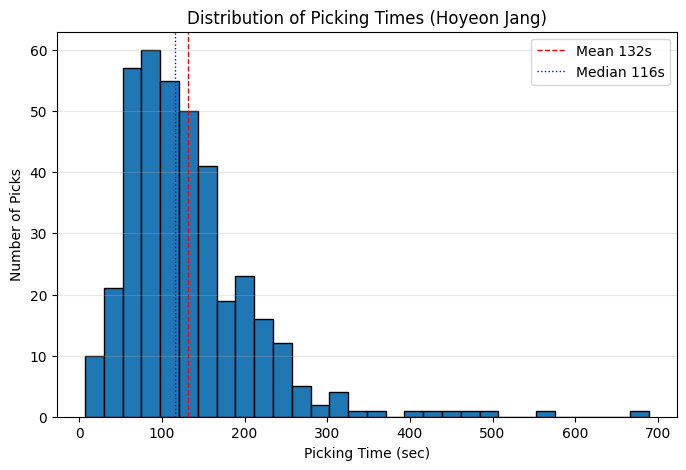

In [41]:
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vQ1eVWTm9TWsfTvFHiiGpelyebYDElKjOifrrrGpLa7hK6ltOOD8DAro1OS7PPS5xexT9_uSW8uJADp/pub?output=csv"
df = pd.read_csv(url)

# 피킹 소요 시간의 분포도

plt.figure(figsize=(8, 5))
plt.hist(df['DurationSec'], bins=30, edgecolor='black')
plt.xlabel('Picking Time (sec)')
plt.ylabel('Number of Picks')
plt.title('Distribution of Picking Times (Hoyeon Jang)')

mean_val   = df['DurationSec'].mean()
median_val = df['DurationSec'].median()
plt.axvline(mean_val,   color='red',  linestyle='--', linewidth=1,
            label=f'Mean {mean_val:.0f}s')
plt.axvline(median_val, color='blue', linestyle=':',  linewidth=1,
            label=f'Median {median_val:.0f}s')
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.show()

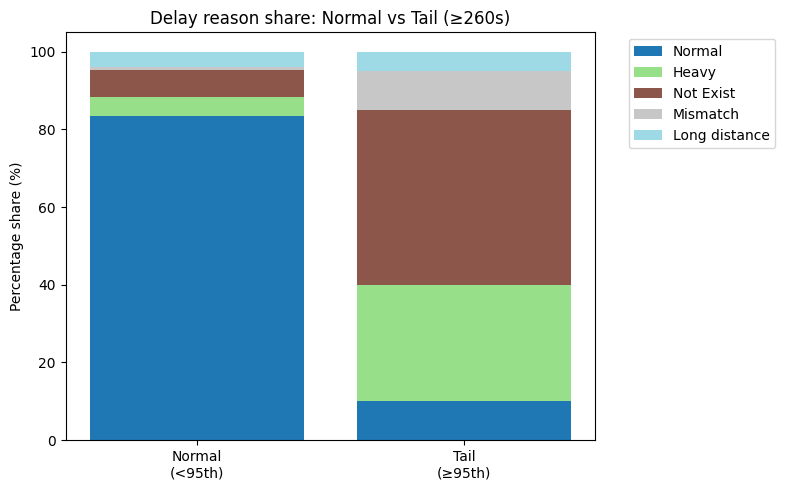

In [47]:
DUR_COL = 'DurationSec'
REASON_COL = 'Result'

reason_map = {
    0: 'Normal',                # 정상 처리
    1: 'Heavy',                 # 고중량
    2: 'Not Exist',             # 재고 없음
    3: 'Mismatch',              # 전산 불일치
    4: 'Long distance'          # 먼거리 이동
}

# 장시간 임계값
tail_thr = np.percentile(df[DUR_COL], 95)   # 95

def share_by_reason(sub):
    c = sub[REASON_COL].value_counts(normalize=True) * 100
    return c

share_normal = share_by_reason(df[df[DUR_COL] <  tail_thr])
share_tail   = share_by_reason(df[df[DUR_COL] >= tail_thr])


all_reasons = share_normal.index.union(share_tail.index)
share_normal = share_normal.reindex(all_reasons, fill_value=0)
share_tail   = share_tail.reindex(all_reasons, fill_value=0)

fig, ax = plt.subplots(figsize=(8,5))
bottom = np.zeros(2)
colors = plt.cm.tab20(np.linspace(0, 1, len(all_reasons)))

for reason, color in zip(all_reasons, colors):
    vals  = [share_normal[reason], share_tail[reason]]
    label = reason_map.get(reason, str(reason))
    ax.bar(['Normal\n(<95th)', 'Tail\n(≥95th)'],
           vals, bottom=bottom, label=label, color=color)
    bottom += vals

ax.set_ylabel('Percentage share (%)')
ax.set_title(f'Delay reason share: Normal vs Tail (≥{tail_thr:.0f}s)')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [11]:
df = df.dropna(subset=["startTime", "DurationSec"]).copy()
df["start_dt"] = pd.to_datetime(df["startTime"])
df.sort_values("start_dt", inplace=True)

inter   = df["start_dt"].diff().dt.total_seconds().dropna()
lam_hat = 60 / inter.mean()                      # orders per minute
service = df["DurationSec"].astype(float).clip(lower=40).values
sampler = lambda rng: rng.choice(service)


print(f"Estimated λ = {lam_hat:.2f} orders/min, sample size = {len(service)}")

Estimated λ = 0.01 orders/min, sample size = 384


In [13]:
base_df  = simulate_mmc(10000, lam_hat, sampler, c=6)
after_df = simulate_mmc(10000, lam_hat, sampler, c=6, improve=0.6)

base_kpi = kpi(base_df); base_kpi.update({"lam":lam_hat, "c":6})
after_kpi = kpi(after_df)

display(pd.DataFrame({"Baseline":base_kpi, "After":after_kpi}).T.round(2))

,Mean(s),P95(s),SLA>10m %,AvgWait(s),lam,c
Baseline,133.55,261.0,0.25,0.0,0.01,6.0
After,80.13,156.6,0.00,0.0,NaN,NaN


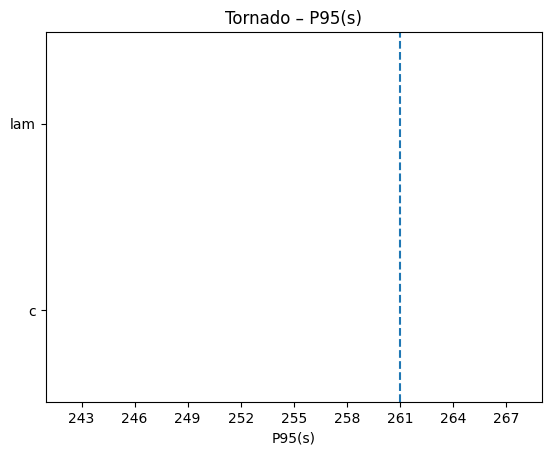

In [14]:
param_grid = {"lam": (lam_hat*0.8, lam_hat*1.2),
              "c"  : (5, 8)}
tornado(base_kpi, param_grid, sampler)

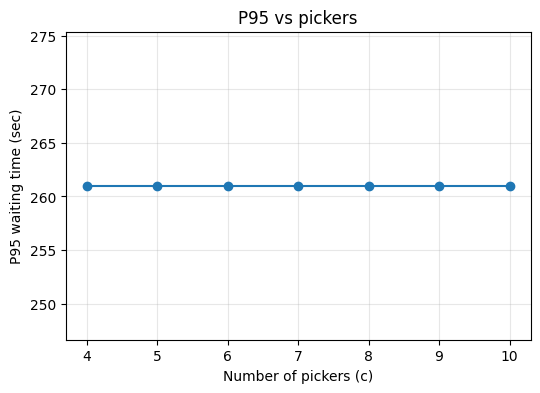

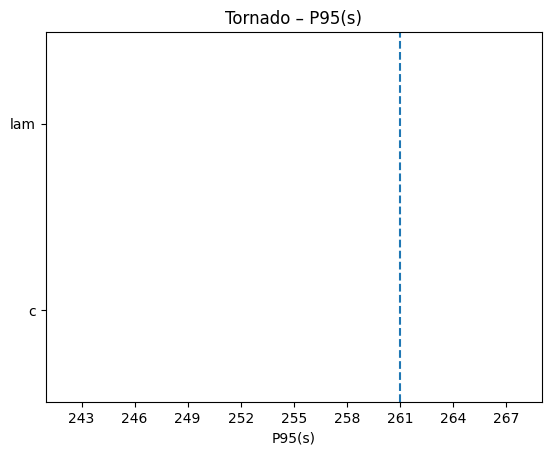

/tmp/ipython-input-59-1187350378.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[-1].set_xticklabels(kpi_df.index, rotation=15)


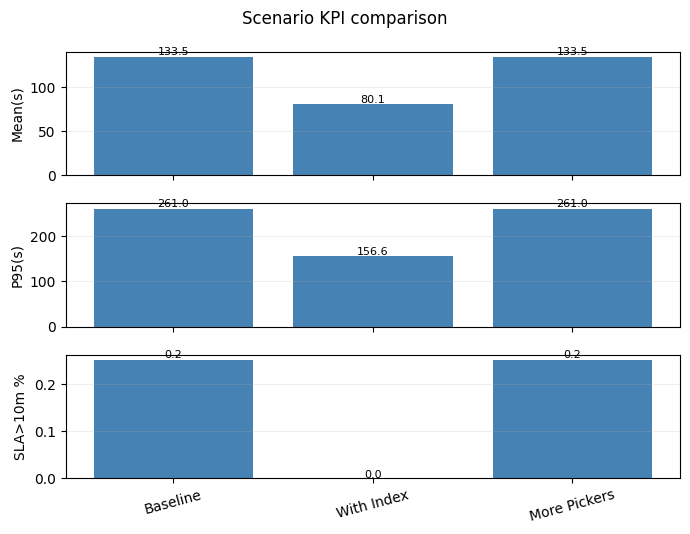

In [59]:
# 1) P95 vs number of pickers -----------------------------------------------
cs = range(4, 11)               # 원하는 범위 조정 가능
p95_curve = []
for c_val in cs:
    out = simulate_mmc(10_000, lam_hat, sampler, c=c_val)   # 1만 주문 시뮬
    p95_curve.append(np.percentile(out["total"], 95))
plt.figure(figsize=(6,4))
plt.plot(cs, p95_curve, marker='o')
plt.xlabel("Number of pickers (c)")
plt.ylabel("P95 waiting time (sec)")
plt.title("P95 vs pickers")
plt.grid(alpha=.3)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

# 2) Tornado chart ( 기존 tornado() 함수 활용 ) ------------------------------
param_grid = {"lam": (lam_hat*0.8, lam_hat*1.2),
              "c"  : (5, 8)}
tornado(base_kpi, param_grid, sampler)          # metric = "P95(s)" 기본값

# 3) Scenario KPI comparison (bar-grid) --------------------------------------
scenarios = {
    "Baseline"      : dict(c=6, improve=1.0),
    "With Index"    : dict(c=6, improve=0.6),
    "More Pickers"  : dict(c=8, improve=1.0)
}

kpi_rows = []
for name, cfg in scenarios.items():
    sim = simulate_mmc(10_000, lam_hat, sampler,
                       c=cfg["c"], improve=cfg["improve"])
    row = kpi(sim)
    row["scenario"] = name
    kpi_rows.append(row)

kpi_df = (pd.DataFrame(kpi_rows)
            .set_index("scenario")
            .loc[list(scenarios)])   # 보장된 순서

metrics = ["Mean(s)", "P95(s)", "SLA>10m %"]
fig, axes = plt.subplots(len(metrics), 1,
                         figsize=(7, 1.8*len(metrics)), sharex=True)
for ax, m in zip(axes, metrics):
    ax.bar(kpi_df.index, kpi_df[m], color="steelblue")
    for idx, val in enumerate(kpi_df[m]):
        ax.text(idx, val*1.02, f"{val:.1f}", ha="center", fontsize=8)
    ax.set_ylabel(m)
    ax.grid(alpha=.2, axis="y")
axes[-1].set_xticklabels(kpi_df.index, rotation=15)
plt.suptitle("Scenario KPI comparison")
plt.tight_layout()
plt.show()